# Проектирование редуктора

## Техническое задание
1. **Расчетная часть.** Спроектировать узел тихоходного вала редуктора вал, колесо, подшипники, уплотнительные элементы, корпус), входящий в схему механического привода.
    1. Силовой и кинематический расчет привода (общий расчет привода), включающий в себя: 
        1. выбор электродвигателя, 
        1. назначение передаточных чисел, 
        1. определение частоты вращения, мощности и крутящего момента на каждом валу привода, сводную таблицу по валам.
    2. Расчет передач редуктора (по заданию), включающего в себя: 
        1. выбор материалов для изготовления механической передачи, (химико-термической обработки с назначением твердости поверхности), 
        1. проектный и проверочный расчет механической передачи. 
    3. Выбор муфт привода.
    4. Проектирование валов редуктора: 
        - Проектный расчет: 
            1. определение минимальных допустимых диаметров валов, 
            1. эскизное конструирование валов с определением диаметральных и линейных размеров тихоходного и быстроходного валов редуктора, 
            1. расчет соединения вала (шпоночного, шлицевого).
        - Проверочный расчет: 
            1. составление расчетной схем быстроходного и тихоходного вала, 
            1. определение реакций, действующих в опорах. 
            1. Построение эпюр изгибающего и крутящего момента, определение опасного сечения (для тихоходного вала), 
            1. проверочный расчет на статическую прочность, 
            1. проверочный расчет на сопротивление усталости (по запасам прочности) тихоходного вала.
    5. Проверка работоспособности подшипников.
    6. Расчет размеров основных корпусных элементов.
    7. Определение размеров крышек подшипников, распорных и мазеудерживающих  колец (при их наличии).
    8. Выбор основных посадок тихоходного вала редуктора.
1. **Графическая часть.**
    1. Разработать уточненный эскиз узла тихоходного вала редуктора (масштаб 1:1, на А3) на миллиметровке.
    2. Создать в КОМПАС модель узла тихоходного вала (по определенным ранее размерам).
    3. Создать в КОМПАС рабочий чертеж тихоходного вала редуктора.

## Список условиных обозначений и сокращений
- КПД = коэффициент полезного действия
- Р = редуктор
- П = подшипник
- М = муфта
- В = вал

# Установка библиотек

In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


# Импорт библиотек

In [2]:
from math import pi, prod, nan, floor
from itertools import product
from matplotlib import pyplot as plt
from typing import List, Tuple

# Вспомогательные переменные и функции

In [3]:
rpm = 60 / (2 * pi)  # об/мин
MPa = 10 ** (-6)  # МПа

In [4]:
def choice(value, values, method: str) -> float | int:
    """Выбор значения из списка по методу"""

    METHODS = ("floor", "nearest", "ceil")

    assert isinstance(value, (int, float)), f"{type(value)=} must be numeric"
    assert isinstance(values, (tuple, list)), f"{type(values)=} must be tuple"
    assert method in METHODS

    if method == "floor":
        for v in values[::-1]:
            if v <= value:
                return v
    elif method == "ceil":
        for v in values:
            if v >= value:
                return v
    elif method == "nearest":
        best = values[0]
        for v in values[1:]:
            if abs(v - value) < abs(best - value):
                best = v
        return best
    else:
        raise ValueError(f"{method=} not in {METHODS}")


def find_best_product(a: float, *numbers: List[float]) -> Tuple[Tuple[float], float]:
    """Подбор лучшей комбинации n множителей из numbers для произведния a"""

    if not numbers:
        raise ValueError("Списоков нет")
    for i, lst in enumerate(numbers):
        if not lst:
            raise ValueError(f"Список {i} пустой")

    best_combination = None
    best_product = 0
    min_relative_error = float("inf")

    for combo in product(*numbers):
        product_val = prod(combo)

        # Используем относительную ошибку
        if a != 0:
            relative_error = abs((product_val - a) / a)
        else:
            relative_error = abs(product_val)

        if relative_error < min_relative_error:
            min_relative_error = relative_error
            best_combination = combo
            best_product = product_val

    return (tuple(best_combination), best_product)


def show_mode_work(relative_time, relative_moment):
    """Визуализация режима работы"""
    time_dur = [0]
    for t in relative_time[:-1]:
        time_dur.append(time_dur[-1] + t)

    plt.figure(figsize=(6, 4))
    plt.title("Режим нагружения")
    plt.grid(True)
    plt.bar(time_dur, relative_moment, width=relative_time, align="edge", edgecolor="black", linewidth=1.5)
    plt.xlabel("t_i / t_sum", fontsize=12)
    plt.ylabel("T / T_max", fontsize=12)
    plt.show()

# Расчет привода

Привод = устройство, предназначенное для приведения в действие машины. В основном, привод - это двигатель, соединенный с передачей.

Расчет привода включает в себя выбор двигателя и определение его (привода)  кинематических и силовых параметров.

На рисунке изображен привод к ленточному конвейеру, состоящий из 
- двигателя, 
- редуктора, 
- предохранительной муфты

![](./assets/images/1.1.png)

## Исходные данные

Исходными данными являются технические данные исполнительного механизма (барабана с лентой).

Параметр | значение | СИ
---|---|---
Натяжение ветвей конвейера | F1, F2 | кН
Скорость ленты | V | м/с
Диаметр барабана | D | м
Ресурс работы | Lh | тыс.час.

In [5]:
# Натяжение ветвей конвеера
F1 = 5.3 * 1000  # Н
F2 = 1.9 * 1000  # Н
# Скороть ленты
v = 1.7  # м/с
# Диаметр барабана
D = 0.22  # м
# Ресурс
Lh = 15 * 1000 * 3600  # c

Режим нагружения

In [6]:
relative_time = [0.7, 0.2, 0.1]
relative_moment = [1, 0.9, 0.5]

assert sum(relative_time) == 1, f"Сумма времени нагружения {relative_time=} != 1"

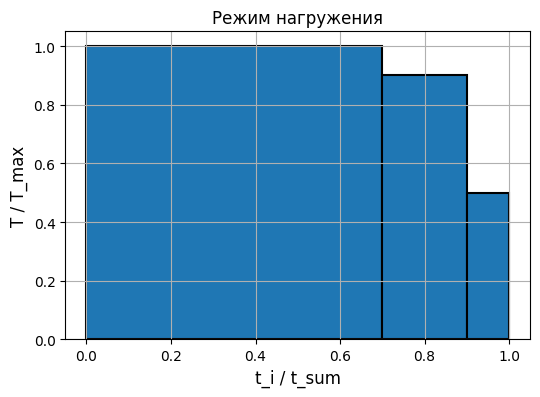

In [7]:
show_mode_work(relative_time, relative_moment)

## Выбор электродвигателя 

При выборе электродвигателя  необходимо определить требуемые мощность и частоту вращения вала двигателя, которые обеспечат работу привода с заданными характеристиками. 

Мощность на приводном валу

In [8]:
P_пр_в = abs(F1 - F2) * v
print(f"{P_пр_в:.1f} Вт")

5780.0 Вт


КПД и передаточные числа передач

Передача | КПД | u
---|---|---
Коническая закрытая | 0,95…0,97 | 1,0…6,3
Цепная открытая | 0.92…0,95 | 1,5…3,0
Ременная открытая | 0,94…0,96 | 2,0…4,0
Муфта соединительная | 0,98…0,99 | -
Муфта предохранительная | 0,99…0,995 | -

Диаппазон значений общего передаточного числа привода 3..18.9

In [9]:
eff_м = 0.98  # КПД муфты соединительной
eff_р = 0.96  # КПД передачи
eff_п = 0.995  # КПД одной пары подшипников

eff_i = (eff_м, eff_р, eff_п)
print(f"{eff_i=}")

eff_i=(0.98, 0.96, 0.995)


Общий КПД привода

In [10]:
eff = prod(eff_i)
print(f"{eff=:.4f}")

eff=0.9361


Требуемая мощность электродвигателя  Рэд.тр.

In [11]:
P_e_req = P_пр_в / eff
print(f"{P_e_req=:.1f} Вт")

P_e_req=6174.6 Вт


По значению Рэд.р. выбирается мощность двигателя Рэд.

Технические характеристики асинхронных трехфазных короткозамкнутых закрытых обдуваемых двигателей с нормальным пусковым моментом

![](./assets/images/engins.png)


In [12]:
ENGINS = (
    # 370
    {"power": 370, "frequency": 1000, "name": "71A4", "rf": 915},
    # 550
    {"power": 550, "frequency": 1500, "name": "71A4", "rf": 1357},
    {"power": 550, "frequency": 1000, "name": "71B6", "rf": 915},
    # 750
    {"power": 750, "frequency": 3000, "name": "71A2", "rf": 2820},
    {"power": 750, "frequency": 1500, "name": "71B4", "rf": 1350},
    {"power": 750, "frequency": 1000, "name": "80A6", "rf": 920},
    {"power": 750, "frequency": 750, "name": "90LA8", "rf": 705},
    # 1100
    {"power": 1100, "frequency": 3000, "name": "71B2", "rf": 2805},
    {"power": 1100, "frequency": 1500, "name": "80A4", "rf": 1395},
    {"power": 1100, "frequency": 1000, "name": "80B6", "rf": 920},
    {"power": 1100, "frequency": 750, "name": "90LB8", "rf": 715},
    # 1500
    {"power": 1500, "frequency": 3000, "name": "80A2", "rf": 2850},
    {"power": 1500, "frequency": 1500, "name": "80B4", "rf": 1395},
    {"power": 1500, "frequency": 1000, "name": "90L6", "rf": 925},
    {"power": 1500, "frequency": 7500, "name": "100L8", "rf": 702},
    # 2200
    {"power": 2200, "frequency": 3000, "name": "80B2", "rf": 2850},
    {"power": 2200, "frequency": 1500, "name": "90L4", "rf": 1395},
    {"power": 2200, "frequency": 1000, "name": "100L6", "rf": 945},
    {"power": 2200, "frequency": 750, "name": "112MA8", "rf": 709},
    # 3000
    {"power": 3000, "frequency": 3000, "name": "90L2", "rf": 2850},
    {"power": 3000, "frequency": 1500, "name": "100S4", "rf": 1410},
    {"power": 3000, "frequency": 1000, "name": "112MA6", "rf": 950},
    {"power": 3000, "frequency": 750, "name": "112MB8", "rf": 709},
    # 4000
    {"power": 4000, "frequency": 3000, "name": "100L2", "rf": 2850},
    {"power": 4000, "frequency": 1500, "name": "100L4", "rf": 1410},
    {"power": 4000, "frequency": 1000, "name": "112MB6", "rf": 950},
    {"power": 4000, "frequency": 750, "name": "132S8", "rf": 716},
    # 5500
    {"power": 5500, "frequency": 3000, "name": "100S2", "rf": 2850},
    {"power": 5500, "frequency": 1500, "name": "112M4", "rf": 1432},
    {"power": 5500, "frequency": 1000, "name": "132S6", "rf": 960},
    {"power": 5500, "frequency": 750, "name": "132M8", "rf": 712},
    # 7500
    {"power": 7500, "frequency": 3000, "name": "112M2", "rf": 2895},
    {"power": 7500, "frequency": 1500, "name": "132S4", "rf": 1440},
    {"power": 7500, "frequency": 1000, "name": "132M6", "rf": 960},
    {"power": 7500, "frequency": 750, "name": "160S8", "rf": 727},
    # 11000
    {"power": 11000, "frequency": 3000, "name": "132M2", "rf": 2910},
    {"power": 11000, "frequency": 1500, "name": "132M4", "rf": 1447},
    {"power": 11000, "frequency": 1000, "name": "160S6", "rf": 970},
    {"power": 11000, "frequency": 750, "name": "160M8", "rf": 727},
    # 15000
    {"power": 15000, "frequency": 3000, "name": "160S2", "rf": 2910},
    {"power": 15000, "frequency": 1500, "name": "160S4", "rf": 1455},
    {"power": 15000, "frequency": 1000, "name": "160M6", "rf": 970},
    {"power": 15000, "frequency": 750, "name": "180M8", "rf": 731},
    # 18500
    {"power": 18500, "frequency": 3000, "name": "160M2", "rf": 2910},
    {"power": 18500, "frequency": 1500, "name": "160M4", "rf": 1455},
    {"power": 18500, "frequency": 1000, "name": "180M6", "rf": 980},
    # 22000
    {"power": 22000, "frequency": 3000, "name": "180S2", "rf": 2919},
    {"power": 22000, "frequency": 1500, "name": "180S4", "rf": 1462},
    # 30000
    {"power": 30000, "frequency": 3000, "name": "180M2", "rf": 2925},
    {"power": 30000, "frequency": 1500, "name": "180M4", "rf": 1470},
)
for e in ENGINS:
    e["frequency"] *= 2 * pi / 60  # перевод в рад/с
    e["rf"] *= 2 * pi / 60  # перевод в рад/с

In [13]:
P_эд = choice(P_e_req, (sorted([engine["power"] for engine in ENGINS])), method="ceil")
print(f"{P_эд=} Вт")

P_эд=7500 Вт


In [14]:
print("Подходящие двигатели:")
engins = [engine for engine in ENGINS if engine["power"] == P_эд]
for i, engine in enumerate(engins):
    print(f"{i}: {engine}")

Подходящие двигатели:
0: {'power': 7500, 'frequency': 314.1592653589793, 'name': '112M2', 'rf': 303.16369107141503}
1: {'power': 7500, 'frequency': 157.07963267948966, 'name': '132S4', 'rf': 150.79644737231007}
2: {'power': 7500, 'frequency': 104.71975511965977, 'name': '132M6', 'rf': 100.53096491487338}
3: {'power': 7500, 'frequency': 78.53981633974483, 'name': '160S8', 'rf': 76.13126197199264}


In [15]:
d_эд = 28 / 1000  # TODO

## 1.2 Выбор частоты вращения вала электродвигателя

Частота вращения приводного вала

In [16]:
n_пр = v / (D / 2)
print(f"{n_пр=:.2f} рад/c")

n_пр=15.45 рад/c


ГОСТ 2144-76

1 ряд | 1,00 | 1,25 | 1,6 | 2,00 | 2,50 | 3,15 | 4,0 | 5,0 | 6,3 | 12,5 | 16 | 20 | 25 | 31,5 | 40 | 50 | 63 | 80
---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---
2 ряд | 1,12 | 1,40 | 1,8 | 2,24 | 2,8 | 3,55 | 4,5 | - | 5,6 | 14 | 18 | 22,4 | 26 | 35,5 | 45 | 56 | 71 | -

In [17]:
U1 = [1, 1.25, 1.6, 2, 2.5, 3.15, 4, 5, 6.3, 12.5, 16, 20, 25, 31.5, 40, 50, 63, 80]  # 1 ряд
U2 = [1.12, 1.4, 1.8, 2.24, 2.8, 3.55, 4.5, 5.6, 14, 18, 22.4, 26, 35.5, 45, 56, 71]  # 2 ряд
U = tuple(sorted(U1 + U2))
print(f"{U=}")

U=(1, 1.12, 1.25, 1.4, 1.6, 1.8, 2, 2.24, 2.5, 2.8, 3.15, 3.55, 4, 4.5, 5, 5.6, 6.3, 12.5, 14, 16, 18, 20, 22.4, 25, 26, 31.5, 35.5, 40, 45, 50, 56, 63, 71, 80)


Рекомендации передаточных чисел:

Передача | min | max
---|---|---
цилиндрическая передача | 2.0 | 6.3
открытая цепная передача | 1.5 | 3.0
открытая ременная передача | 2.5 | 4.0

Задаем списки-выбора передаточных чисел для каждого соединения

In [18]:
U_i = (
    [1],  # муфта
    U,  # редуктор
    [1],  # муфта
)

assert len(U_i) == len(eff_i), f"количество соедниений {len(eff_i)} != количесву передаточных чисел {len(U_i)}"
for el in U_i:
    assert isinstance(el, (tuple, list)), f"{type(el)=} must be tuple"

Общее передаточное число привода и распределение по передачам

In [19]:
del_engins = []
for i, engine in enumerate(engins):
    u_о = engine["rf"] / n_пр  # оющее передаточное число
    u_i, u_o_ = find_best_product(u_о, *U_i)  # количество соединений
    print(f"\n{engine['name']}: {u_о=:.2f} = {u_i} = {u_o_:.2f}", end=" ")

    if not (3 <= u_о and u_о <= 18.9):
        print("(не подходит по общему передаточному числу [3..18.9])", end="")
        del_engins.append(i)

for i in del_engins:
    del engins[i]  # удаление неподходящих двигателей


112M2: u_о=19.62 = (1, 20, 1) = 20.00 (не подходит по общему передаточному числу [3..18.9])
132S4: u_о=9.76 = (1, 12.5, 1) = 12.50 
132M6: u_о=6.50 = (1, 6.3, 1) = 6.30 
160S8: u_о=4.93 = (1, 5, 1) = 5.00 

## 1.3 Кинематический и силовой расчет привода

In [20]:
n_shafts = len(eff_i) + 1  # количество валов

data = []
for i, engine in enumerate(engins):
    print(f"engine {i}: {engine['name']}")

    P_i = [P_e_req]  # требуемая мощность
    n_i = [engine["rf"]]
    T_i = [P_i[0] / n_i[0]]
    d_i = [d_эд]

    u_о = engine["rf"] / n_пр  # оющее передаточное число
    u_i, u_o_ = find_best_product(u_о, *U_i)  # количество соединений

    for j in range(n_shafts):
        print(f"\tshaft {j}:")
        print(f"\t\t{P_i[j]=:<10.1f} Вт")
        print(f"\t\t{n_i[j]=:<10.1f} рад/c")
        print(f"\t\t{T_i[j]=:<10.3f} Н*м")
        print(f"\t\t{d_i[j]=:<10.3f} м")

        print()

        is_last = j == n_shafts - 1  # последний (выходной) вал

        if not is_last:  # не последний
            print(f"\tconnection {j}-{j + 1}:")
            print(f"\t\t{eff_i[j]=:<10.4f}")
            print(f"\t\t{u_i[j]=:<10}")

            print()

            P_i.append(P_i[j] * eff_i[j])
            n_i.append(n_i[j] / u_i[j])
            T_i.append(P_i[j + 1] / n_i[j + 1])

            if i == 0:
                c = 8
            elif i == 1:
                c = 6
            else:
                c = 5
            d_i.append(c / 1000 * (T_i[j]) ** (1 / 3))

    data.append({"i": i, "engine": engine, "u_i": u_i, "P_i": P_i, "n_i": n_i, "T_i": T_i, "d_i": d_i})

engine 0: 132S4
	shaft 0:
		P_i[j]=6174.6     Вт
		n_i[j]=150.8      рад/c
		T_i[j]=40.946     Н*м
		d_i[j]=0.028      м

	connection 0-1:
		eff_i[j]=0.9800    
		u_i[j]=1         

	shaft 1:
		P_i[j]=6051.1     Вт
		n_i[j]=150.8      рад/c
		T_i[j]=40.128     Н*м
		d_i[j]=0.028      м

	connection 1-2:
		eff_i[j]=0.9600    
		u_i[j]=12.5      

	shaft 2:
		P_i[j]=5809.0     Вт
		n_i[j]=12.1       рад/c
		T_i[j]=481.530    Н*м
		d_i[j]=0.027      м

	connection 2-3:
		eff_i[j]=0.9950    
		u_i[j]=1         

	shaft 3:
		P_i[j]=5780.0     Вт
		n_i[j]=12.1       рад/c
		T_i[j]=479.123    Н*м
		d_i[j]=0.063      м

engine 1: 132M6
	shaft 0:
		P_i[j]=6174.6     Вт
		n_i[j]=100.5      рад/c
		T_i[j]=61.420     Н*м
		d_i[j]=0.028      м

	connection 0-1:
		eff_i[j]=0.9800    
		u_i[j]=1         

	shaft 1:
		P_i[j]=6051.1     Вт
		n_i[j]=100.5      рад/c
		T_i[j]=60.191     Н*м
		d_i[j]=0.024      м

	connection 1-2:
		eff_i[j]=0.9600    
		u_i[j]=6.3       

	shaft 2:
		P_i[j]=5809.0     Вт

In [21]:
for d in data:
    print(f"engine {d['i']}: {d['engine']}")
    print(f"\teff_i: {eff_i}")
    print(f"\tu_i:   {d['u_i']}")
    print(f"\tP_i:   {[round(v, 1) for v in d['P_i']]}")
    print(f"\tn_i:   {[round(v, 4) for v in d['n_i']]}")
    print(f"\tT_i:   {[round(v, 3) for v in d['T_i']]}")
    print(f"\td_i:   {[round(v, 4) for v in d['d_i']]}")
    print()

engine 0: {'power': 7500, 'frequency': 157.07963267948966, 'name': '132S4', 'rf': 150.79644737231007}
	eff_i: (0.98, 0.96, 0.995)
	u_i:   (1, 12.5, 1)
	P_i:   [6174.6, 6051.1, 5809.0, 5780.0]
	n_i:   [150.7964, 150.7964, 12.0637, 12.0637]
	T_i:   [40.946, 40.128, 481.53, 479.123]
	d_i:   [0.028, 0.0276, 0.0274, 0.0627]

engine 1: {'power': 7500, 'frequency': 104.71975511965977, 'name': '132M6', 'rf': 100.53096491487338}
	eff_i: (0.98, 0.96, 0.995)
	u_i:   (1, 6.3, 1)
	P_i:   [6174.6, 6051.1, 5809.0, 5780.0]
	n_i:   [100.531, 100.531, 15.9573, 15.9573]
	T_i:   [61.42, 60.191, 364.037, 362.217]
	d_i:   [0.028, 0.0237, 0.0235, 0.0428]

engine 2: {'power': 7500, 'frequency': 78.53981633974483, 'name': '160S8', 'rf': 76.13126197199264}
	eff_i: (0.98, 0.96, 0.995)
	u_i:   (1, 5, 1)
	P_i:   [6174.6, 6051.1, 5809.0, 5780.0]
	n_i:   [76.1313, 76.1313, 15.2263, 15.2263]
	T_i:   [81.104, 79.482, 381.515, 379.608]
	d_i:   [0.028, 0.0216, 0.0215, 0.0363]



В виду того, что при одинаковой мощности электодвигателей 
- цена обратно пропорциональна частоте его вращения
- двигатели с низкими частотами вращения весьма металлоемки 
- двигатели с большой частотой имеют низкий рабочий ресурс

Выбираем самый экономичный двигатель

In [22]:
choice = data[0]  # выбор двигателя по номеру

engine = choice["engine"]
u_i = choice["u_i"]
P_i = choice["P_i"]
n_i = choice["n_i"]
T_i = choice["T_i"]
d_i = choice["d_i"]

print(f"engine:    {engine}")
print()
print(f"u_i:       {u_i}")
print(f"P_i кВт:   {[round(v / 1000, 3) for v in P_i]}")
print(f"n_i рад/с: {[round(v, 2) for v in n_i]}")
print(f"T_i Н*м:   {[round(v, 2) for v in T_i]}")
print(f"d_i мм:    {[round(v * 1000, 2) for v in d_i]}")

engine:    {'power': 7500, 'frequency': 157.07963267948966, 'name': '132S4', 'rf': 150.79644737231007}

u_i:       (1, 12.5, 1)
P_i кВт:   [6.175, 6.051, 5.809, 5.78]
n_i рад/с: [150.8, 150.8, 12.06, 12.06]
T_i Н*м:   [40.95, 40.13, 481.53, 479.12]
d_i мм:    [28.0, 27.57, 27.39, 62.7]


# Выбор твердости, термической обработки и материалов колес

![](./assets/images/to.png)

![](./assets/images/sigma_1.png)
![](./assets/images/sigma_2.png)

In [23]:
hardness = 45  # HRC
Cv = 930
sigma_lim_H_1, sigma_lim_H_2 = (17 * hardness + 200) * 10**6, (17 * hardness + 200) * 10**6

print(f"{sigma_lim_H_1 * MPa=}")
print(f"{sigma_lim_H_2 * MPa=}")

sigma_lim_H_1 * MPa=965.0
sigma_lim_H_2 * MPa=965.0


# Выбор степени точности изготовления зубчастых колес

Ожидаемая окружная скорость

In [24]:
v_u = (n_i[1] * rpm / Cv) * (T_i[1 + 1] / u_i[1] ** 2) ** (1 / 3)
print(f"{v_u=:.2f} м/с")

v_u=2.25 м/с


Угол наулона зубьев

In [25]:
a_teeth = 35  # град

assert 0 <= a_teeth <= 35

Степень точности 

зубчатое колесо | (0..2] | (2..4] | (4..6] | (6..10] | (10..16]
---|---|---|---|---|---
прямозубое | 8(9) | 8 | 7 | 6 | -
косозубое и шевронное | 8(9) | 8(9) | 8 | 7 | 6

Для косозубой передачи при окружной скорости менее 2 м/с принимается 8 степень точности

In [26]:
quality = nan
if a_teeth == 0:
    if 0 < v_u <= 2:
        quality = 8
    elif 2 < v_u <= 4:
        quality = 8
    elif 4 < v_u <= 6:
        quality = 7
    elif 6 < v_u <= 10:
        quality = 6
else:
    if 0 < v_u <= 2:
        quality = 8
    elif 2 < v_u <= 4:
        quality = 8
    elif 4 < v_u <= 6:
        quality = 8
    elif 6 < v_u <= 10:
        quality = 7
    elif 10 < v_u <= 16:
        quality = 6
print(f"{quality=}")

quality=8


# Выбор коэффициента относительной ширины зубчастого колеса

Степень точности | 5, 6 | 7 | 8 | 9, 10
---|---|---|---|---
HB<350 | 1.5..2.0 | 1.0..1.5 | 0.75..1.0 | 0.75
HRC>350 | 1.0..1.5 | 0.7..1.0 | 0.5..0.7 | 0.5

In [27]:
phi = nan
if quality == 5 or quality == 6:
    if hardness < 350:
        phi = (1.5 + 2.0) / 2
    else:
        phi = (1.0 + 1.5) / 2
elif quality == 7:
    if hardness < 350:
        phi = (1.0 + 1.5) / 2
    else:
        phi = (0.7 + 1.0) / 2
elif quality == 8:
    if hardness < 350:
        phi = (0.75 + 1.0) / 2
    else:
        phi = (0.5 + 0.7) / 2
elif quality == 9 or quality == 10:
    if hardness < 350:
        phi = 0.75
    else:
        phi = 0.5
print(f"{phi=}")

phi=0.875


# Определение коэффициента учета неравномерности распределения нагрузки по длине контактных линий

![](./assets/images/k_hb.png)

In [28]:
print(f"{hardness=}")
print(f"{phi=}")

hardness=45
phi=0.875


In [29]:
k_hb = 1.15

# Определение коэффициентов режимов работы

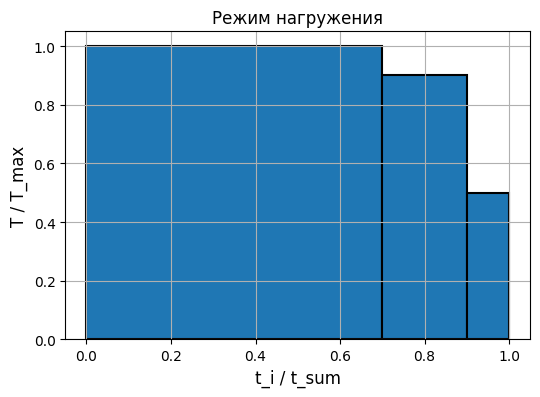

In [30]:
show_mode_work(relative_time, relative_moment)

In [31]:
mu = sum(relative_time[i] * (relative_moment[i]) ** 3 for i in range(len(relative_time)))
print(f"{mu=:.4f}")

mu=0.8583


## Расчет суммарных, эквивалентных и базовых чисел циклов

Число зацеплений зуба за 1 оборот

In [32]:
n_contact = 1

Суммарное число циклов нагружения

In [33]:
N_sum = 60 * n_contact * (n_i[1] * rpm) * (Lh / 3600)
N_sum = floor(N_sum)
print(f"{N_sum=:_}")

N_sum=1_296_000_000


Эквивалентное число циклов службы

In [34]:
N_HE = mu * N_sum
N_HE = floor(N_HE)
print(f"{N_HE=:_}")

N_HE=1_112_356_800


Базовое число циклов

In [35]:
N_HG = min(340 * hardness**3.15 + 8 * 10**6, 120 * 10**6)  # для HRC
N_HG = round(N_HG)
print(f"{N_HG=:_}")

N_HG=62_840_112


## Расчет коэффициента долговечности

In [36]:
Z_N = 0
if N_HE <= N_HG:
    Z_N = (N_HG / N_HE) ** (1 / 6)
else:
    Z_N = min(
        (N_HG / N_HE) ** (1 / 20),
        0.75,
    )
print(f"{Z_N=}")

Z_N=0.75


## Определение пределов контактной выносливости

In [37]:
Z_R = 0.9  # влияние исходной шероховатости поверхностей зубьев
Z_V = 0.9  # влияние окружной скорости
Z_X = 0.9  # влияние размеров зубчатого колеса

Коэффициент запаса

In [38]:
S_H = 1.2

In [39]:
sigma_H_1 = sigma_lim_H_1 * Z_N * Z_R * Z_V * Z_X / S_H
sigma_H_2 = sigma_lim_H_2 * Z_N * Z_R * Z_V * Z_X / S_H

## Допускаемое контактное напряжение

In [51]:
sigma_H = None
if a_teeth == 0:  # прямое
    sigma_H = min(sigma_H_1, sigma_H_2)
else:  # косозубое
    sigma_H = 0.45 * (sigma_H_1 + sigma_H_2)

print(f"{sigma_H * MPa=:.1f}")

sigma_H * MPa=395.7


## Выбор коэффициентов запасов прочности колес

## Определение допускаемых контакных напряжений

# Расчет геометрических параметров зубчатой передачи

# Расчет подшипников

Подшипник и его параметры:

In [42]:
bearing = "46207 ГОСТ 831-75"

x_b, y_b = 1, 0
e = 0.68
C_b = 100_000  # Н

Нагрузка:

In [43]:
# частота вращения
n = 221.42 * 2 * pi / 60  # рад/с
# Окружная сила

# Радиальная сила
F_r = 15  # Н
# Осевая сила
F_a = 0  # Н

Коэффициенты запаса:

In [44]:
k_safety = 1.3
k_t = 1

In [45]:
P_r = (v * x_b * F_r + y_b * F_a) * k_safety * k_t
print(f"{P_r=:.2f} Н")

P_r=33.15 Н


In [46]:
a1 = 0.62
a2 = 0.8

In [47]:
C_r = P_r * (Lh * n / 2 / pi / a1 / a2 / 10**6) ** 3
print(f"{C_r=} Н")

C_r=2149891639.8024764 Н


In [48]:
assert C_r <= C_b, AssertionError(f"Требуемая грузоподъемность {C_r} > паспортной грузоподъемности {C_b}")

AssertionError: Требуемая грузоподъемность 2149891639.8024764 > паспортной грузоподъемности 100000

In [ ]:
# k_h = () ** (1 / 3)

Ресурс работы П:

In [ ]:
L_b = (a1 * a2) * (C_r / P_r) ** 3
print(f"{L_b=:.0f} с = {L_b / 3600:.0f} ч")

L_b=18158947533978364542976 с = 5044152092771768320 ч


In [ ]:
assert Lh / 2 < L_b < 2 * Lh

AssertionError: 

Проверка неусталостного разрушения:

In [ ]:
assert P_r < C_r / 2